In [644]:
import os
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [645]:
cwd = os.getcwd()
# Find and import config file
config_path = os.getcwd()

sys.path.append(config_path)
import config

In [646]:
database = config.database
central_banks = config.central_banks
training_data = os.path.join(database, "Training Data")
fed_docs = config.fed_docs
ecb_docs = config.ecb_docs

In [647]:
sentiment = pd.date_range(start="1/1/1999", end="1/1/2024", freq="D")
sentiment = pd.DataFrame(sentiment, columns=["date"])

In [648]:
# HP Filter

# url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

# for i in range(len(url_map)):
#     if url_map["central bank"][i] == "fed" and url_map["document"][i] == "speeches":
#         speeches = pd.read_csv(url_map["finbert_url"][i])

# speeches["date"] = pd.to_datetime(speeches["date"], format='%Y%m%d')

# fed_speech = speeches.copy(deep=True)

# fed_speech = fed_speech[["date", "sentiment"]]
# fed_speech = fed_speech.rename(columns={"sentiment": "fed_speech_sentiment"})
# fed_speech["date"] = pd.to_datetime(fed_speech["date"])

# fed_speech = fed_speech.resample("Q", on="date").mean().reset_index()

# filter_df = fed_speech.copy(deep=True)
# filter_df = filter_df[["date", "fed_speech_sentiment"]]

# cycle, trend = sm.tsa.filters.hpfilter(filter_df["fed_speech_sentiment"], 1600)

# filter_df["fed_speech_sentiment_cycle"] = cycle
# filter_df["fed_speech_sentiment_trend"] = trend

# filter_df = filter_df[["date", "fed_speech_sentiment_cycle"]]
# fed_speech = fed_speech.drop(columns=["fed_speech_sentiment"])
# filter_df = filter_df.rename(
#     columns={"fed_speech_sentiment_cycle": "fed_speech_sentiment"}
# )
# fed_speech = pd.merge(fed_speech, filter_df, on="date", how="left")
# fed_speech = fed_speech.groupby("date").mean().reset_index()

# sentiment = pd.merge(sentiment, fed_speech, how="left", left_on="date", right_on="date")

In [649]:
url_map = pd.read_csv(os.path.join(cwd, "url_map.csv"))

for i in range(len(url_map)):
    sent = pd.read_csv(url_map["finbert_url"][i])
    sent = sent[["date", "sentiment"]]
    sent = sent.rename(columns={"sentiment": url_map["document"][i] + "_sentiment"})
    sent["date"] = pd.to_datetime(sent["date"])
    sent = sent.groupby("date").mean().reset_index()

    sentiment = pd.merge(sentiment, sent, how="left", left_on="date", right_on="date")

In [650]:
# Forward fill all NA data in the sentiment DataFrame
sentiment.ffill(inplace=True)

In [651]:
# All Sentiment
sentiment_columns = [col for col in sentiment.columns if col.endswith("_sentiment")]
sentiment_columns_no_ma = [
    col for col in sentiment_columns if not col.endswith("_90d_ma")
]
sentiment["daily_average_sentiment"] = sentiment[sentiment_columns_no_ma].mean(axis=1)

In [652]:
sentiment["us_sentiment"] = sentiment[
    [
        "fed_speeches_sentiment",
        "minutes_sentiment",
        "statements_sentiment",
        "beigebooks_sentiment",
    ]
].mean(axis=1)

sentiment["eu_sentiment"] = sentiment[
    [
        "ecb_speeches_sentiment",
        "monetary policy accounts_sentiment",
        "economic bulletins_sentiment",
        "press conferences_sentiment",
    ]
].mean(axis=1)

In [653]:
# All Speech Sentiment
sentiment["speech_sentiment"] = sentiment[
    ["fed_speeches_sentiment", "ecb_speeches_sentiment"]
].mean(axis=1)

In [654]:
mich = pd.read_csv(
    "/Users/kylenabors/Documents/Database/Market Data/Michigan/michigan_sent.csv"
)
# convert Month from a string to a number
mich["Month"] = mich["Month"].str.replace("January", "01")
mich["Month"] = mich["Month"].str.replace("February", "02")
mich["Month"] = mich["Month"].str.replace("March", "03")
mich["Month"] = mich["Month"].str.replace("April", "04")
mich["Month"] = mich["Month"].str.replace("May", "05")
mich["Month"] = mich["Month"].str.replace("June", "06")
mich["Month"] = mich["Month"].str.replace("July", "07")
mich["Month"] = mich["Month"].str.replace("August", "08")
mich["Month"] = mich["Month"].str.replace("September", "09")
mich["Month"] = mich["Month"].str.replace("October", "10")
mich["Month"] = mich["Month"].str.replace("November", "11")
mich["Month"] = mich["Month"].str.replace("December", "12")

# combine Month and YYYY columns and convert to datetime
mich["date"] = mich["Month"].astype(str) + "-" + mich["YYYY"].astype(str)
mich["date"] = pd.to_datetime(mich["date"])
mich = mich[["date", "ICS_ALL"]]
mich = mich.rename(columns={"ICS_ALL": "michigan_sentiment"})

sentiment = pd.merge(sentiment, mich, how="outer", left_on="date", right_on="date")


vix = pd.read_csv("/Users/kylenabors/Documents/Database/Market Data/VIX/VIX.csv")
vix = vix[["date", "sentiment"]]
vix = vix.rename(columns={"sentiment": "vix"})
vix["date"] = pd.to_datetime(vix["date"])
sentiment = sentiment.merge(vix, how="left", left_on="date", right_on="date")


# Filter the sentiment DataFrame to keep all data after 1 Jan 2000
sentiment = sentiment[sentiment["date"] >= "2000-01-01"]

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_85773/3669895643.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mich["date"] = pd.to_datetime(mich["date"])


In [655]:
# Forward fill all NA data in the sentiment DataFrame
sentiment.ffill(inplace=True)

In [656]:
# Calculate the 90-day moving average for all columns except 'date'
for column in sentiment.columns:
    if column != "date":
        sentiment[column] = sentiment[column].rolling(window=90).mean()

In [657]:
from sklearn.preprocessing import MinMaxScaler

# Select sentiment columns (excluding the date column)
sentiment_columns = sentiment.columns.difference(["date"])

# Initialize the MinMaxScaler with feature range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the sentiment columns
sentiment[sentiment_columns] = scaler.fit_transform(sentiment[sentiment_columns])

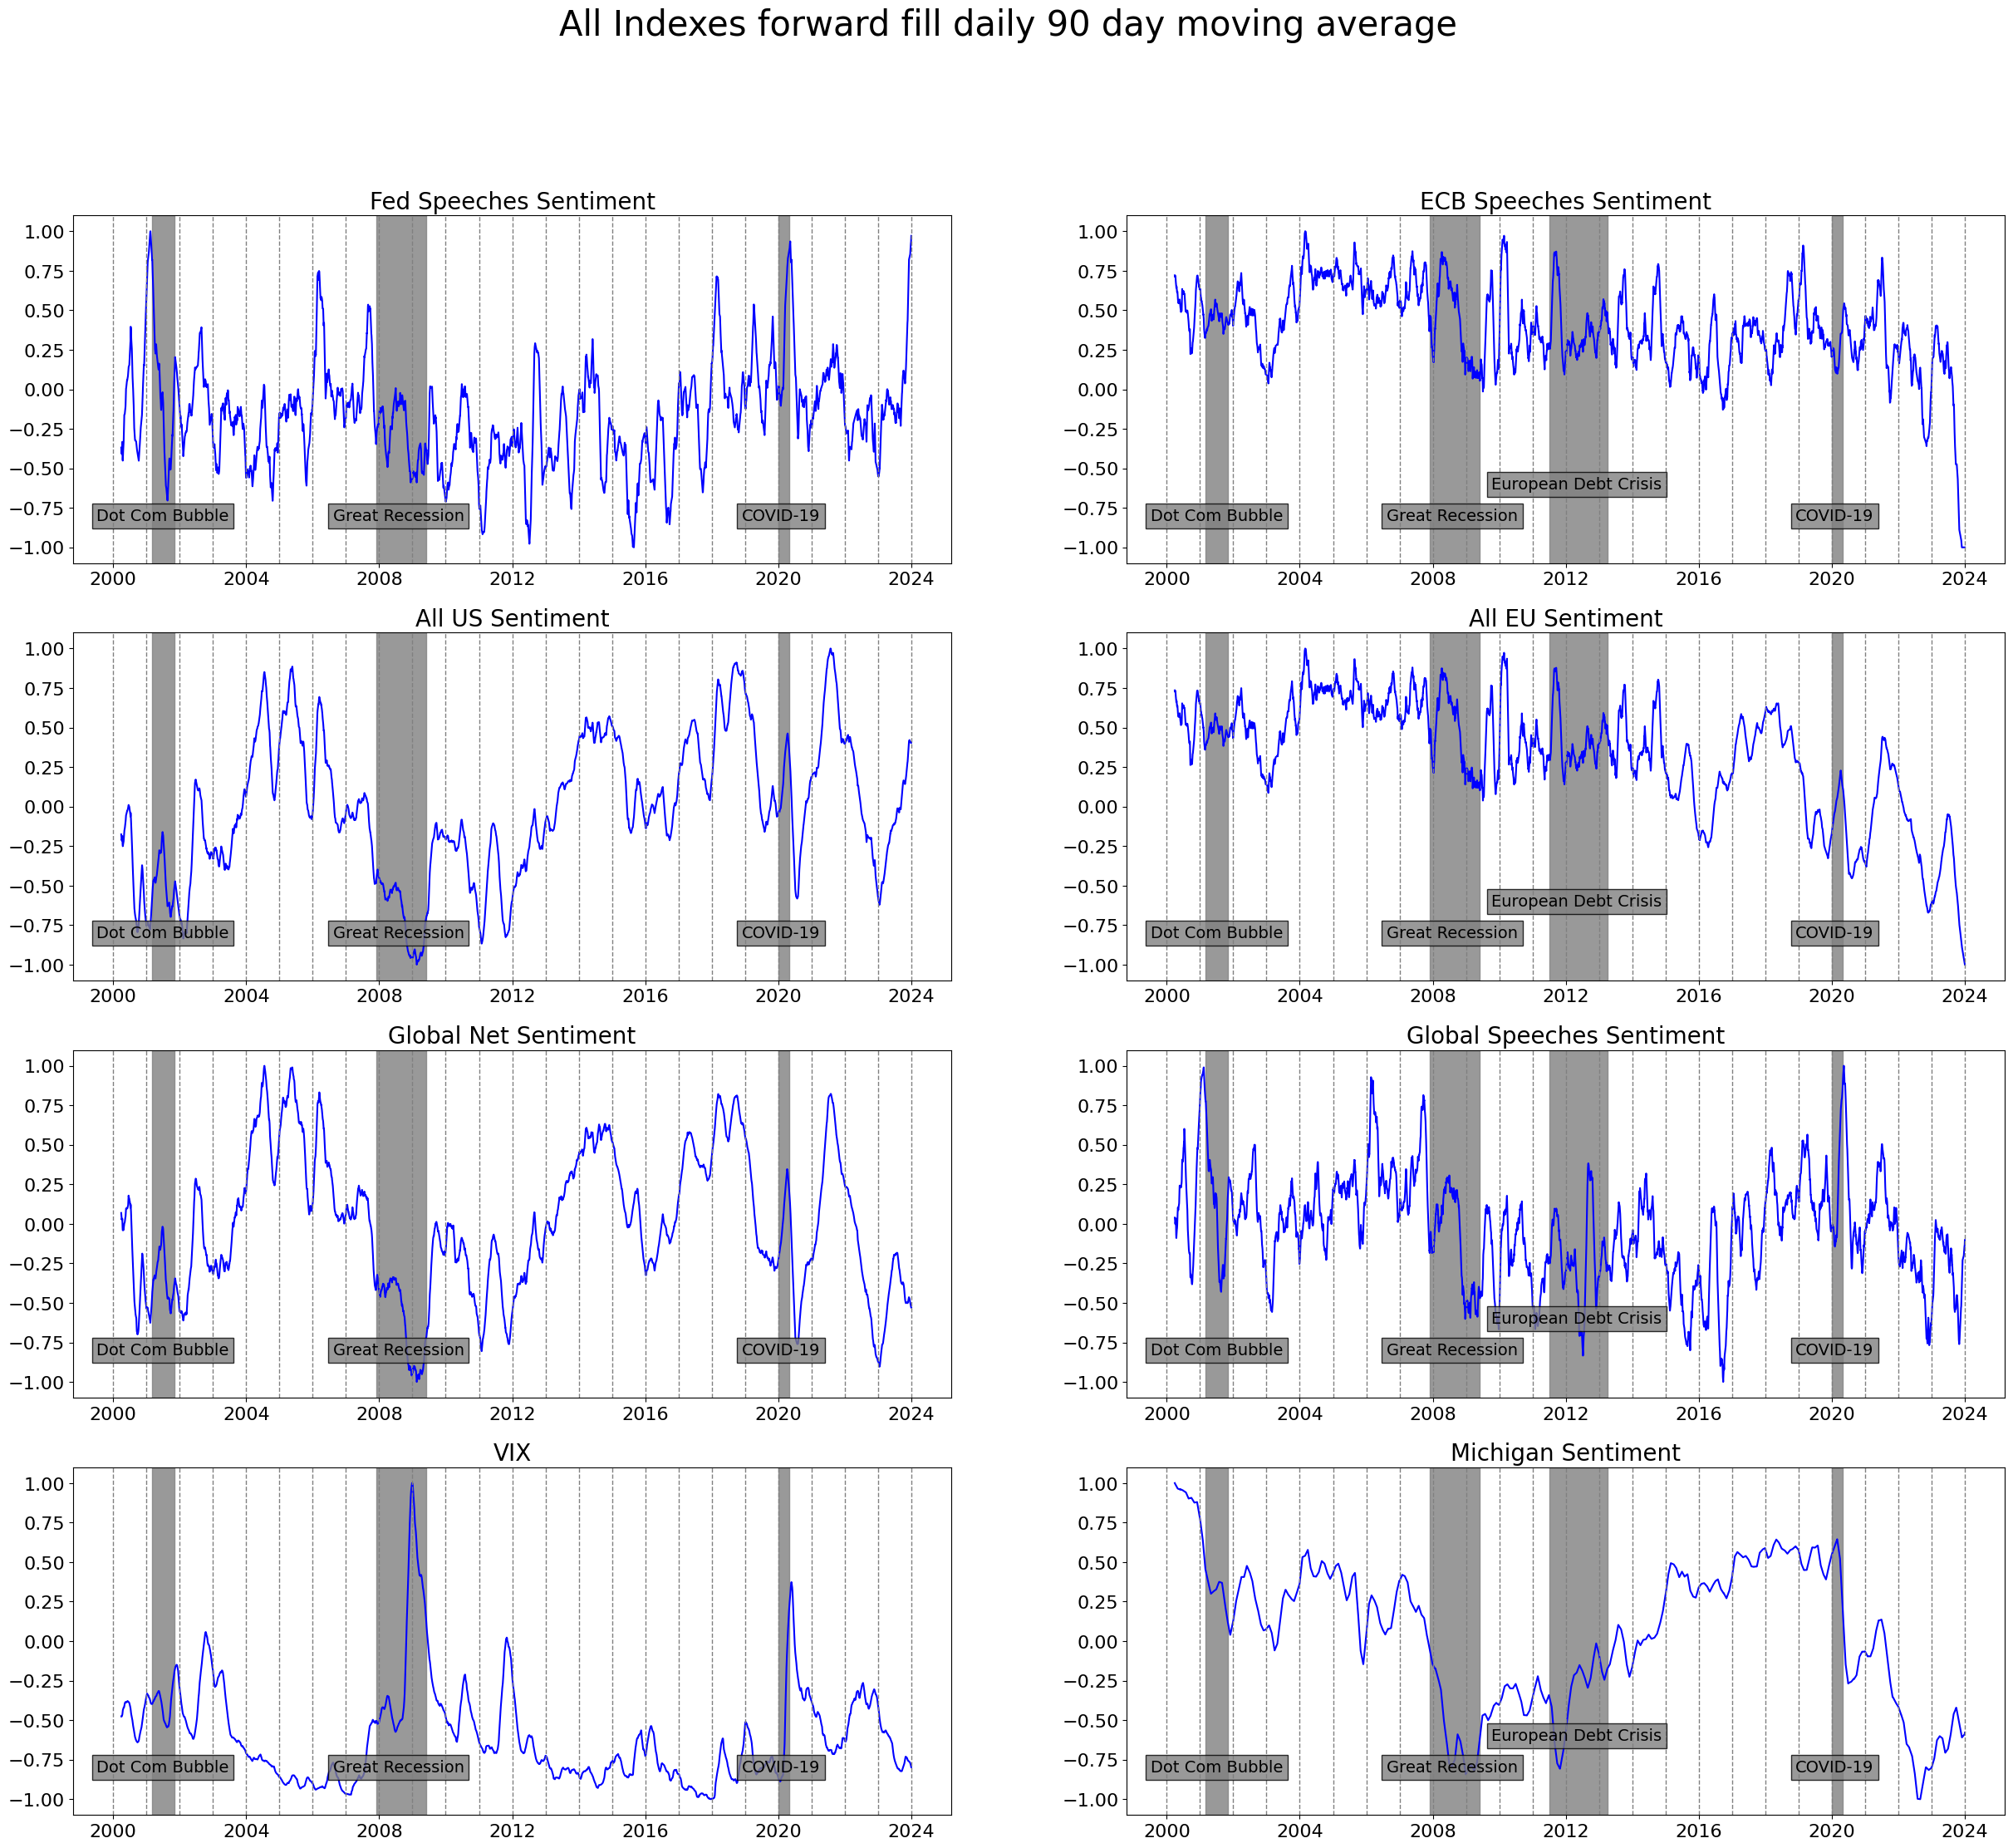

In [658]:
# recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
fig, ax = plt.subplots(4, 2, figsize=(30, 25))

# Add a big title at the top of the graphs
# fig.suptitle('All Indexes forward fill daily', fontsize=30)
fig.suptitle("All Indexes forward fill daily 90 day moving average", fontsize=30)


min = -1
max = 1.01

ax[0, 0].plot(
    sentiment["date"],
    sentiment["fed_speeches_sentiment"],
    color="blue",
)

ax[0, 0].set_title("Fed Speeches Sentiment", fontsize=20)  # Adjust font size

ax[0, 1].plot(
    sentiment["date"],
    sentiment["ecb_speeches_sentiment"],
    color="blue",
)
ax[0, 1].set_title("ECB Speeches Sentiment", fontsize=20)  # Adjust font size

ax[1, 0].plot(
    sentiment["date"],
    sentiment["us_sentiment"],
    color="blue",
)
ax[1, 0].set_title("All US Sentiment", fontsize=20)  # Adjust font size

ax[2, 0].plot(
    sentiment["date"],
    sentiment["daily_average_sentiment"],
    color="blue",
)
ax[2, 0].set_title("Global Net Sentiment", fontsize=20)  # Adjust font size

ax[1, 1].plot(
    sentiment["date"],
    sentiment["eu_sentiment"],
    color="blue",
)
ax[1, 1].set_title("All EU Sentiment", fontsize=20)  # Adjust font size

ax[2, 1].plot(
    sentiment["date"],
    sentiment["speech_sentiment"],
    color="blue",
)
ax[2, 1].set_title("Global Speeches Sentiment", fontsize=20)  # Adjust font size

ax[3, 1].plot(
    sentiment["date"],
    sentiment["michigan_sentiment"],
    color="blue",
)
ax[3, 1].set_title("Michigan Sentiment", fontsize=20)  # Adjust font size

ax[3, 0].plot(
    sentiment["date"],
    sentiment["vix"],
    color="blue",
)
ax[3, 0].set_title("VIX", fontsize=20)  # Adjust font size

yticks = np.arange(min, max, 0.25)  # Define yticks

for i in range(4):
    for j in range(2):
        # ax[i, j].tick_params(axis="both", labelsize=14)
        ax[i, j].set_yticks(yticks)  # Set yticks
        ax[i, j].tick_params(axis="y", labelsize=16)  # Increase y-axis label font size
        ax[i, j].tick_params(axis="x", labelsize=16)  # Increase y-axis label font size

lh = -0.8
crisis_font = 14

# Create a vertical line at every year
for i in range(4):
    # European Debt Crisis
    ax[i, 1].axvspan(
        pd.to_datetime("2011-07-01"),
        pd.to_datetime("2013-04-01"),
        color="gray",
        alpha=0.8,
    )
    ax[i, 1].text(
        pd.to_datetime("2012-05-01"),
        -0.6,
        "European Debt Crisis",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=crisis_font,  # Adjust font size
        bbox=dict(facecolor="gray", alpha=0.8),
    )
    for j in range(2):
        for year in range(2000, 2025):
            ax[i, j].axvline(
                pd.to_datetime(f"{year}-01-01"), color="gray", linestyle="--", lw=1
            )

        # Great Recession
        ax[i, j].axvspan(
            pd.to_datetime("2007-12-01"),
            pd.to_datetime("2009-06-01"),
            color="gray",
            alpha=0.8,
        )
        ax[i, j].text(
            pd.to_datetime("2008-08-01"),
            lh,
            "Great Recession",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=crisis_font,  # Adjust font size
            bbox=dict(facecolor="gray", alpha=0.8),
        )

        # COVID
        ax[i, j].axvspan(
            pd.to_datetime("2020-01-01"),
            pd.to_datetime("2020-05-01"),
            color="gray",
            alpha=0.8,
        )
        ax[i, j].text(
            pd.to_datetime("2020-02-01"),
            lh,
            "COVID-19",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=crisis_font,  # Adjust font size
            bbox=dict(facecolor="gray", alpha=0.8),
        )

        # Dot Com Bubble
        ax[i, j].axvspan(
            pd.to_datetime("2001-03-01"),
            pd.to_datetime("2001-11-01"),
            color="gray",
            alpha=0.8,
        )
        ax[i, j].text(
            pd.to_datetime("2001-07-01"),
            lh,
            "Dot Com Bubble",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=crisis_font,  # Adjust font size
            bbox=dict(facecolor="gray", alpha=0.8),
        )

plt.show()

# Save the graph as a png file to /Users/kylenabors/Documents/Database/Photos
fig.savefig("/Users/kylenabors/Documents/Database/Photos/Sentiment Graph.png")